## Import Library

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import time
import joblib
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    # confusion_matrix,
    ConfusionMatrixDisplay
)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

## Mount Drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/AI-Career-Planner/data/processed/Clean Dataset/cleaned_data.csv")
df.head()

,job_title_clean,job_summary_clean,skills_token,input_text
0,veterinary receptionist,join the adventure at austin bluffs animal cli...,"['veterinary_receptionist', 'aahaaccredited', ...",veterinary receptionist join the adventure at ...
1,travel allied health professional ct technologist,flexcare imaging is seeking a travel ct techno...,"['ct_technologist', 'allied_health_professiona...",travel allied health professional ct technolog...
2,assistant general manager,an assistant general manager is the agms provi...,"['hiring', 'training', 'retaining', 'developin...",assistant general manager an assistant general...
3,internal auditor,details open date 01 10 2024 requisition numbe...,"['accounting', 'auditing', 'gaap', 'tax_laws',...",internal auditor details open date 01 10 2024 ...
4,audit manager,job details description keiter mission help pe...,"['accounting_principles', 'auditing_standards'...",audit manager job details description keiter m...


In [4]:
df.isnull().sum()

,0
job_title_clean,0
job_summary_clean,0
skills_token,0
input_text,0


## Cek Duplicate Rows

In [5]:
# Cek duplicate berdasarkan input_text (title + skills + summary)
print("="*80)
print("DUPLICATE ANALYSIS".center(80))
print("="*80)

# Total duplicates
total_duplicates = df["input_text"].duplicated().sum()
print(f"Duplicate Statistics:")
print(f"   - Total duplicates             : {total_duplicates:,}")
print(f"   - Percentage                   : {(total_duplicates/len(df)*100):.2f}%")

# Cek apakah duplicate memiliki job_title yang sama atau beda
duplicated_rows = df[df["input_text"].duplicated(keep=False)]
print(f"   - Total rows with duplicates   : {len(duplicated_rows):,}")

# Apakah duplicate punya label yang sama?
duplicate_check = df[df["input_text"].duplicated(keep=False)].groupby("input_text")["job_title_clean"].nunique()
mixed_labels = (duplicate_check > 1).sum()
print(f"   - Duplicates with MIXED labels : {mixed_labels}")
print(f"   - Duplicates with SAME label   : {len(duplicate_check) - mixed_labels}")

                               DUPLICATE ANALYSIS                               
Duplicate Statistics:
   - Total duplicates             : 0
   - Percentage                   : 0.00%
   - Total rows with duplicates   : 0
   - Duplicates with MIXED labels : 0
   - Duplicates with SAME label   : 0


## Label encoding

In [6]:
X = df["input_text"].astype(str)
y = df["job_title_clean"].astype(str)

le = LabelEncoder()
y_enc = le.fit_transform(y)

joblib.dump(le, "/content/drive/MyDrive/AI-Career-Planner/models/data_model_mlp_knn/label_encoder.joblib")
print("✔ Label encoder saved.")

✔ Label encoder saved.


## Train test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

print(f"Data Split:")
print(f"   - Training samples   : {len(X_train)}")
print(f"   - Testing samples    : {len(X_test)}")

Data Split:
   - Training samples   : 208127
   - Testing samples    : 52032


## TF-IDF

In [8]:
start_time = time.time()

tfidf = TfidfVectorizer(
    max_features=25000,
    ngram_range=(1, 2),
    stop_words="english",
    sublinear_tf=True,
    min_df=2,
    max_df=0.95
)

In [9]:
# Deklarasi variable (transform)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [10]:
joblib.dump(tfidf, "/content/drive/MyDrive/AI-Career-Planner/models/data_model_mlp_knn/tfidf_vectorizer.joblib")
print(f"TF-IDF vectorizer saved (features: {X_train_tfidf.shape[1]})")
print(f"   Time taken: {time.time() - start_time:.2f}s")

TF-IDF vectorizer saved (features: 25000)
   Time taken: 379.57s


## Training Model

Model 1 : MLP Classifier (Neural Network)

In [ ]:
import time
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    print(f"\n{'='*50}")
    print(f"TRAINING {model_name.upper()}")
    print(f"{'='*50}")

    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f}s")

    print(f"\n{'='*50}")
    print(f"EVALUATING {model_name.upper()}")
    print(f"{'='*50}")

    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time
    print(f"Prediction time: {prediction_time:.2f}s")

    # Assuming `le` (LabelEncoder) is available in the global scope
    # to get target names for the classification report.
    try:
        target_names = le.classes_
    except NameError:
        target_names = None
        print("Warning: LabelEncoder 'le' not found. Classification report will not display target names.")

    print(classification_report(y_test, y_pred, target_names=target_names))

    return model, y_pred

# NOTE: After running this cell, you can re-run the KNN model cell (and any other models that use evaluate_model).

In [ ]:
from sklearn.neural_network import MLPClassifier

# MODEL 5: MLP Classifier (Neural Network)
# MLP (Multi-Layer Perceptron) sangat baik untuk menangkap pola non-linear
# pada data teks yang kompleks.

# Konfigurasi MLP
# - hidden_layer_sizes=(128, 64): Dua layer tersembunyi (Deep Learning simpel)
# - activation='relu': Standar industri untuk fungsi aktivasi
# - solver='adam': Optimizer yang efisien untuk data besar
# - early_stopping=True: Berhenti jika akurasi tidak naik (biar gak kelamaan)
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    max_iter=600,
    early_stopping=True,
    validation_fraction=0.1,
    verbose=True,
    random_state=42
)

mlp_model, mlp_pred = evaluate_model(
    mlp_model,
    "MLP Classifier",
    X_train_tfidf,
    X_test_tfidf,
    y_train,
    y_test
)

# Save model
joblib.dump(mlp_model, "/content/drive/MyDrive/AI-Career-Planner/models/data_model_mlp_knn/model_mlp_classifier.joblib")
print(f"\nModel saved: /content/drive/MyDrive/AI-Career-Planner/models/data_model_mlp_knn/model_mlp_classifier.joblib")


TRAINING MLP CLASSIFIER
Iteration 1, loss = 1.51597908
Validation score: 0.878184
Iteration 2, loss = 0.27520353
Validation score: 0.932351
Iteration 3, loss = 0.13449908
Validation score: 0.947566
Iteration 4, loss = 0.08316796
Validation score: 0.950888
Iteration 5, loss = 0.06028908
Validation score: 0.954548
Iteration 6, loss = 0.04915320
Validation score: 0.954307
Iteration 7, loss = 0.04380398
Validation score: 0.952814
Iteration 8, loss = 0.03970476
Validation score: 0.956811
Iteration 9, loss = 0.03610676
Validation score: 0.957388
Iteration 10, loss = 0.03480580
Validation score: 0.957822
Iteration 11, loss = 0.03364825
Validation score: 0.958496
Iteration 12, loss = 0.03227966
Validation score: 0.958014
Iteration 13, loss = 0.03208781
Validation score: 0.958014
Iteration 14, loss = 0.03019337
Validation score: 0.959218
Iteration 15, loss = 0.02967067
Validation score: 0.959363
Iteration 16, loss = 0.02800953
Validation score: 0.960470
Iteration 17, loss = 0.02773267
Validati

Model 2 : KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# MODEL 6: KNN (K-Nearest Neighbors)
# KNN cocok untuk dataset ini karena mengklasifikasikan data berdasarkan
# 'kedekatan' dengan K tetangga terdekat di ruang fitur (TF-IDF).
# Untuk klasifikasi teks, efektivitasnya bisa sangat bergantung pada representasi
# fitur (TF-IDF) dan pemilihan 'n_neighbors'.

# Konfigurasi KNN
# - n_neighbors=5: Jumlah tetangga yang akan dipertimbangkan. Nilai umum.
# - algorithm='auto': Algoritma heuristik untuk mencari tetangga terdekat.
# - metric='cosine': Jarak kosinus sering lebih efektif untuk data teks
#   daripada jarak Euclidean, karena mengukur kemiripan arah vektor.
knn_model = KNeighborsClassifier(
    n_neighbors=5,
    algorithm='auto',
    metric='cosine' # Cosine similarity for text data
)

knn_model, knn_pred = evaluate_model(
    knn_model,
    "KNN Classifier",
    X_train_tfidf,
    X_test_tfidf,
    y_train,
    y_test
)

# Save model
joblib.dump(knn_model, "/content/drive/MyDrive/AI-Career-Planner/models/data_model_mlp_knn/model_knn.joblib")
print(f"\nModel saved: /content/drive/MyDrive/AI-Career-Planner/models/data_model_mlp_knn/model_knn.joblib")


TRAINING KNN CLASSIFIER
Training time: 1.50s

EVALUATING KNN CLASSIFIER
Prediction time: 2830.51s
                                                                         precision    recall  f1-score   support

                                  25b information technology specialist       1.00      1.00      1.00        44
                       92a automated logistical specialist supply chain       1.00      1.00      1.00        99
                           92y unit supply specialist warehouse manager       1.00      1.00      1.00        95
                                                      account executive       0.69      0.83      0.75       524
                                                        account manager       0.60      0.56      0.58       185
                                                             accountant       0.44      0.49      0.47       288
                                                     accounting manager       0.73      0.78      0.76       

In [ ]:
import time
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    print(f"\n{'='*50}")
    print(f"TRAINING {model_name.upper()}")
    print(f"{'='*50}")

    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f}s")

    print(f"\n{'='*50}")
    print(f"EVALUATING {model_name.upper()}")
    print(f"{'='*50}")

    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time
    print(f"Prediction time: {prediction_time:.2f}s")

    # Assuming `le` (LabelEncoder) is available in the global scope
    # to get target names for the classification report.
    try:
        target_names = le.classes_
    except NameError:
        target_names = None
        print("Warning: LabelEncoder 'le' not found. Classification report will not display target names.")

    print(classification_report(y_test, y_pred, target_names=target_names))

    return model, y_pred


Accuracy Comparison:
   - MLP Classifier : 0.9606
   - KNN Classifier : 0.8463


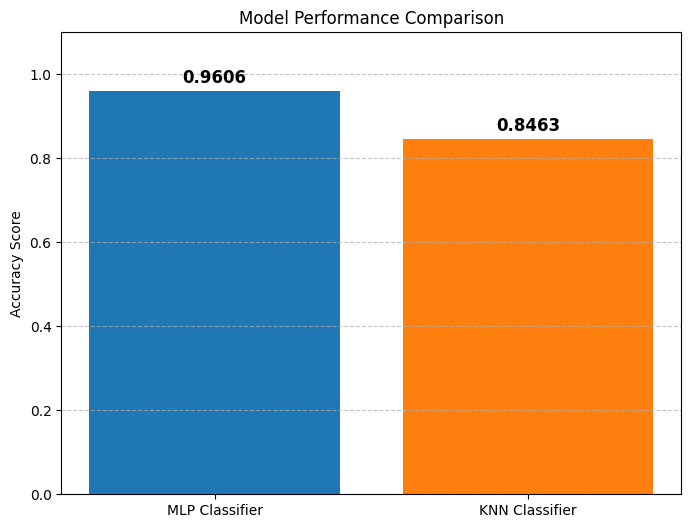


BEST MODEL IDENTIFIED: MLP Classifier with accuracy 0.9606
[Artifacts Package] Saved to: /content/drive/MyDrive/AI-Career-Planner/models/model_comparison.joblib
[Best Model] Saved to: /content/drive/MyDrive/AI-Career-Planner/models/model_bestmodel.joblib


In [ ]:
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.metrics import accuracy_score

# --- 1. Compare Accuracy ---
acc_mlp = accuracy_score(y_test, mlp_pred)
acc_knn = accuracy_score(y_test, knn_pred)

print(f"Accuracy Comparison:")
print(f"   - MLP Classifier : {acc_mlp:.4f}")
print(f"   - KNN Classifier : {acc_knn:.4f}")

# --- 2. Visualize Performance ---
models = ['MLP Classifier', 'KNN Classifier']
accuracies = [acc_mlp, acc_knn]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['#1f77b4', '#ff7f0e'])
plt.ylim(0, 1.1) # Set y-axis limit sedikit di atas 1 agar teks terlihat
plt.ylabel('Accuracy Score')
plt.title('Model Performance Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

# --- 3. Identify Best Model ---
if acc_mlp > acc_knn:
    best_model = mlp_model
    best_model_name = "MLP Classifier"
    best_acc = acc_mlp
else:
    best_model = knn_model
    best_model_name = "KNN Classifier"
    best_acc = acc_knn

print(f"\nBEST MODEL IDENTIFIED: {best_model_name} with accuracy {best_acc:.4f}")

# --- 4. Save Artifacts ---
save_dir = "/content/drive/MyDrive/AI-Career-Planner/models/data_model_mlp_knn/"
os.makedirs(save_dir, exist_ok=True)

# A. Save LabelEncoder, TfidfVectorizer, and Best Model into model_comparison.joblib
# Menyimpan sebagai dictionary agar semua komponen penting ada dalam satu file paket
comparison_package = {
    'label_encoder': le,
    'tfidf_vectorizer': tfidf,
    'best_model': best_model,
    'model_name': best_model_name,
    'accuracy': best_acc,
    'comparison_stats': {'MLP': acc_mlp, 'KNN': acc_knn}
}

comparison_path = os.path.join(save_dir, "model_comparison.joblib")
joblib.dump(comparison_package, comparison_path)
print(f"[Artifacts Package] Saved to: {comparison_path}")

# B. Save ONLY the Best Model into model_bestmodel.joblib
best_model_path = os.path.join(save_dir, "best_model.joblib")
joblib.dump(best_model, best_model_path)
print(f"[Best Model] Saved to: {best_model_path}")